In [224]:
from datetime import datetime, timedelta
import os, argparse, sys
import matplotlib.pyplot as plt
import numpy as np
from numpy.polynomial import Polynomial
import pandas as pd
from glob import glob
from datetime import datetime, timedelta
from dateutil.parser import parse as parse_to_datetime
import imageio
import openpyxl
import sklearn

import platform
import os

In [225]:
######################## PROFILE PLOT ####################################   
## User Input from excel config file

#reading in user input from excel config excel file
config_path = "makeprofileplot_config.xlsx" #Location of excel user file
config = pd.read_excel(config_path, skiprows=2, engine='openpyxl', usecols='A:C', index_col=0, nrows=22) # Need to download openpyxl package to import xlsx
print(config)
skiprows = config.at['Skip Rows', config.columns[0]]
x_label = config.at['X Label', config.columns[0]]
x_min = config.at['X Axis (min, max)', config.columns[0]]
x_max = config.at['X Axis (min, max)', config.columns[1]]
y_label = config.at['Y Label', config.columns[0]]
y_min = config.at['Y Axis (min, max)', config.columns[0]]
y_max = config.at['Y Axis (min, max)', config.columns[1]]
start_day = config.at['Julian Start Day', config.columns[0]]
obsdatapath = config.at['File', config.columns[0]]
obs_day_column_name = config.at['Date Column', config.columns[0]]
obs_variable = config.at['Variable Name', config.columns[0]]
obs_variable_units = config.at['Variable Units', config.columns[0]]
obs_variable_column_name = config.at['Variable Column Name', config.columns[0]]
obs_depth_column_name = config.at['Depth Column Name', config.columns[0]] 
obs_result_column_name = config.at['Result Column Name', config.columns[0]]
obs_na_values = config.at['NA Values', config.columns[0]]
figure_title = config.at['Figure Title', config.columns[0]]
# NOTE: append "_column_name" to variables that store labels (names of columns)
modpath = config.at['File', config.columns[1]]
mod_day_column_name = config.at['Date Column', config.columns[1]]
mod_variable = config.at['Variable Name', config.columns[1]]
mod_variable_column_name = config.at['Variable Column Name', config.columns[1]]
mod_depth_column_name = config.at['Depth Column Name', config.columns[1]] 
mod_result_column_name = config.at['Result Column Name', config.columns[1]]
mod_na_values = config.at['NA Values', config.columns[0]]
mod_variable_units = config.at['Variable Units', config.columns[1]]

profileplotfolder = config.at['Profile Plots Folder', config.columns[0]] 
statsfolder = config.at['Statistic Output Folder', config.columns[0]]
#print(obsdatapath, obs_day, obs_param, modpath, mod_day, mod_param, profileplotfolder)





                                                                   Unnamed: 1  \
$ 3/11/22                                                                       
File                             data\Model Files\HaggRes_InletStreams_WQ.csv   
Sheet Name                                                                NaN   
Skip Rows                                                                 NaN   
Variable Column Name                                            Lab Parameter   
Variable Name                                                     Temperature   
Variable Units                                                        Celsius   
Result Column Name                                                Result_as#2   
Depth Column Name                                                     Depth_m   
NA Values                                                                -999   
Legend Label                                                         Observed   
Date Column                 

In [226]:
# If linux environment, change '\' to '/' for directory compatibility and add entire path
if platform.system() != 'Windows':
    modpath = os.getcwd() + '/' + modpath.replace('\\', '/') # Add working directory path to variable and change '\'
    obsdatapath = os.getcwd() + '/' + obsdatapath.replace('\\', '/') # Add working directory path to variable and change '\'
    profileplotfolder = os.getcwd() + '/' + profileplotfolder.replace('\\', '/')

# If directories for paths dont exist, create them
path_list = [modpath, obsdatapath, profileplotfolder]
if platform.system() != 'Windows':
    dir_split = '/'
else:
    dir_split = '\\'

for variable in path_list:
    build_path = ''
    path = variable.split(os.getcwd() + dir_split)[1].split(dir_split) # split path into array
    path.pop() # Remove filename from end
    
    for directory in path:
        build_path += directory + dir_split
        print(build_path)
        if not os.path.isdir(build_path):
            os.mkdir(build_path)

data/
data/Model Files/
data/
data/Model Files/
plots/


In [227]:

# loading in model and observed data

print('loading model "%s"' % modpath)
print('loading observed "%s"' % obsdatapath)

#read in profile model outputs
moddata = pd.read_csv(modpath, na_values=mod_na_values)

#observed data
obsdata = pd.read_csv(obsdatapath, na_values= obs_na_values)

loading model "/u/ttotten/side_projects/project_capstone/CE-QUAL-W2-Data-Visualization/data/Model Files/spr_wb1.csv"
loading observed "/u/ttotten/side_projects/project_capstone/CE-QUAL-W2-Data-Visualization/data/Model Files/HaggRes_InletStreams_WQ.csv"


In [228]:
#Conditional Statements - Create tables for observed and modeled data
#### This requires data to be in a specific format ####
#Create model data table, round down days
profobs = obsdata[(obsdata['Site'] == 'V - Hagg Lake')].copy() # conditions data to only include Site V, makes a copy so we dont alter obs data
profobs = profobs[(profobs[obs_variable_column_name] == obs_variable)]
profobs = profobs[[obs_day_column_name, obs_depth_column_name, obs_result_column_name]] #making a table with day, depth, and results
profobs[obs_day_column_name] = profobs[obs_day_column_name].apply(np.floor) #round down
profobs = profobs.dropna()

#Create observed data table, round down days
profmod = moddata[(moddata[mod_variable_column_name] == mod_variable)].copy() 
profmod = profmod[[mod_day_column_name, mod_depth_column_name, mod_result_column_name]]
profmod[mod_day_column_name] = profmod[mod_day_column_name].apply(np.floor)
profmod = profmod.dropna()

#use this if you want to see the data
#print('Observed data:')
#print(profobs)
#print('Model data:')
#print(profmod)

In [229]:
#create a model days and observed days into a se
modeldays = set(profmod[mod_day_column_name])
observeddays = set(profobs[obs_day_column_name])
days =  modeldays.intersection(observeddays) #find the ones that are in both data sets



In [230]:
#Create Index of Days in Model Dataset - In the future we may need to check that observed and modeled days match earlier in code
#mod_ind = profmod_complete[mod_day].unique() # prof mod complete not defined
#mod_ind #Index of Julian Days for model dataset. We are assuming the model days match the observed days.

# renaming variables so they specify that they are interpolated!
interpolated_df_day_column_name = mod_day_column_name
interpolated_df_depth_column_name = 'Depth' #mod_depth_column_name
interpolated_df_mod_result_column_name = mod_result_column_name
interpolated_df_obs_result_column_name = obs_result_column_name
interpolated_columns = [
    interpolated_df_day_column_name, 
    interpolated_df_depth_column_name, 
    interpolated_df_mod_result_column_name, 
    interpolated_df_obs_result_column_name,
]


interpolated_df = pd.DataFrame(columns=interpolated_columns) #creating an empty data frame to put all of the interpolated values in

#Interpolate - each days values are interpolated using this loop

for i in days: # changed this to modeldays instead of mod_ind
    profmod_i = profmod[(profmod[mod_day_column_name] == i)]
    profobs_i = profobs[(profobs[obs_day_column_name] == i)]
    
    mod_depths = profmod_i[mod_depth_column_name]
    mod_results = profmod_i[mod_result_column_name]
    
    obs_depths = profobs_i[obs_depth_column_name]
    obs_results = profobs_i[obs_result_column_name]

    # if there are no observed depths for day "i" np.interp will crash below. 
    # so, if there are none, skip this day (via "continue")
    # if len(obs_depths) == 0:
    #     print('no observed depths for day {}'.format(i))
    #     continue
    
    interp_mod_results = list(np.interp(obs_depths, mod_depths, mod_results))
    interp_mod_days = [i] * len(obs_depths)
    interpolated_df = pd.concat([
        interpolated_df, 
        pd.DataFrame(zip(interp_mod_days, obs_depths, interp_mod_results, obs_results), columns=interpolated_columns)
    ])

# new data frame will have day, depth, interpolated model data, observed data

In [231]:
#Function to Caluclate Statistic Values
from sklearn.metrics import mean_absolute_error, mean_squared_error

stats_columns = [
    'DAY',
    'MAE', 
    'RMSE', 
    'ME',
    'MODEL ST.DEV',
    'PBIAS',
    'MOD_MEAN',
    'OBS_MEAN',
]
def make_empty_statsdf():
    return pd.DataFrame(columns=stats_columns)

def concat_statsdf(statsdf, df, day):
    y_true = df[interpolated_df_obs_result_column_name].to_numpy()
    y_pred = df[interpolated_df_mod_result_column_name].to_numpy()
    MOD_MEAN = y_pred.mean()
    OBS_MEAN = y_true.mean()
    RMSE = np.sqrt(mean_squared_error(y_true, y_pred))
    ME = np.sum(y_pred - y_true) / len(y_true)
    MAE = np.sum(np.absolute(y_pred - y_true))/ len(y_true)
    MOD_ST_DEV = y_pred.std()
    PBIAS = 100 * np.sum(y_true - y_pred) / np.sum(y_true)
    return pd.concat([
        statsdf,
        pd.DataFrame([[day, MAE, RMSE, ME,MOD_ST_DEV, PBIAS, MOD_MEAN, OBS_MEAN]], columns=stats_columns)
    ])


ValueError: Format 'jpg' is not supported (supported formats: eps, pdf, pgf, png, ps, raw, rgba, svg, svgz)

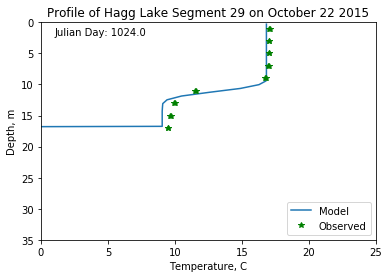

In [232]:
# iterate over the interpolated_df we created above
#creating the profile plots

statsdf = make_empty_statsdf()

for i in days:
    interp_i = interpolated_df[(interpolated_df[interpolated_df_day_column_name] == i)]
    mod_i = profmod[(profmod[mod_day_column_name]==i)]
    depths = list(interp_i[interpolated_df_depth_column_name])
    mod_depths = list(mod_i[mod_depth_column_name])
    x_mod = list(mod_i[mod_result_column_name])
    x_obs = list(interp_i[interpolated_df_obs_result_column_name])
    date = start_day + timedelta(days=i)
    fig, ax = plt.subplots()
    ax.plot(x_mod, mod_depths, marker = '', linestyle ='-', label = 'Model')
    ax.plot(x_obs, depths, marker ='*', linestyle = 'None', color ='g', label = 'Observed')
    plt.title(f"{figure_title} {date.strftime('%B %d %Y')}" )
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(loc = 'lower right')
    ax.set_xlim([x_min, x_max])
    ax.set_ylim([y_min, y_max])
    ax.invert_yaxis()
    ax.axis([x_min, x_max, y_max, y_min])
    ax.text( 1, 2 , f"Julian Day: {i}")
    plotname = f'profmod_{i}.jpg'

    # If profileplotfolder doesnt exist, create it
    if not os.path.isdir(profileplotfolder):
        os.mkdir(profileplotfolder)
    fig.savefig(os.path.join(profileplotfolder, plotname))
    fig.clf()
    
    statsdf = concat_statsdf(statsdf, interp_i, i).sort_values('DAY') # calling the statistics function in this loop to calculate for everyday

    
statsdf = concat_statsdf(statsdf, interpolated_df, 'AVG') #average statistics values
statsdf.to_csv(os.path.join(statsfolder, 'Statistics.csv'))

In [ ]:
# Create Gif of profile plots (Cui Yong, 2020)
from pathlib import Path
image_path = Path(profileplotfolder)
images = list(image_path.glob('*.jpg'))
image_list = []
for file_name in images:
    image_list.append(imageio.imread(file_name))
len(image_list)
imageio.mimwrite(os.path.join(profileplotfolder, 'profileplots.gif'), image_list , fps =4)
file_name